# Getting Your Data From Yelp!

## Part 2 - Create ETL pipeline for the business data from the API

Now that you know what data you need from the API, you want to write code that will execute a api call, parse those results and then insert the results into the DB.  

It is helpful to break this up into three different functions (*api call, parse results, and insert into DB*) and then you can write a function/script that pull the other three functions together. 

Let's first do this for the Business endpoint.

- Write a function to make a call to the yelp API

In [21]:
import pandas as pd
import requests
import json
url = 'https://api.yelp.com/v3/businesses/search'
api_key = "S3cROVIGs17gTiCO6iy8-2ycbL999zhz84ANxStc2mYNESu0cKfM4qdarKNZ69t-2bnTPSR_RRTTCTKmpQidQYhD1mpVN1zvyo0EGTVthI7SVumcOA3IZrRgj5omYHYx"
headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }
# what type of business do you want to search
term = 'Thai'
term2 = 'Mexican'
#where do you want to perform this search
location = 'Queens'

# what is your other parameter you want to search against
categories = 'restaurants'
url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "limit": 50,
                "offset": None
    
            }
url_params2 = {
                "term": term2.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "categories" : categories,
                "limit": 50,
    
            }

In [2]:
response = requests.get(url, headers=headers, params=url_params)
response.status_code

200

In [2]:

def yelp_call(url_params):
    
    response = requests.get(url, headers=headers, params=url_params)
    return response.json()['businesses']
    

- Write a function to parse the API response so that you can easily insert the data in to the DB

In [3]:
def parse_results(list_of_data):
    # create a container to hold our parsed data
    biz_list = []
    # loop through our business and 
    for business in list_of_data:
    # parse each individual business into a tuple
        try:
            biz_tuple = (business['id'],
                     business['name'],
                     business['location']['address1'],
                     business['rating'],
                     business['price'],
                     business['location']['zip_code'],
                     business['transactions'],
                     business['review_count'],
                     business['categories'])   
    # add each individual business tuple to our data container
            biz_list.append(biz_tuple)
        except:
            continue
    # return the container with all of the parsed results
    return biz_list

- Write a function to take your parsed data and add it to the csv file where you will store all of your results. 

In [33]:
# thai_df = pd.DataFrame(parsed_thai, columns = ['Id','Name', 'Location', 'Rating', 'Price', 'Zipcode', 'Transactions', 'Review Count', 'Categories'])

In [34]:
# mex_df = pd.DataFrame(parsed_mex, columns = ['Id','Name', 'Location', 'Rating', 'Price', 'Zipcode', 'Transactions', 'Review Count', 'Categories'])

In [4]:
def df_save(csv_file_path, parsed_results):
    # your code to open the csv file, concat the current data, and save the data. 
    business_df = pd.DataFrame(parsed_results, columns = ['Id','Name', 'Location', 'Rating', 'Price', 'Zipcode', 'Transactions', 'Review Count', 'Categories'])
    business_df.to_csv(csv_file_path, mode = 'a')
    new_df = pd.read_csv(csv_file_path, delimiter = ",")
    return new_df
#     pd.DataFrame(parsed_results).to_csv()

- Write a script that combines the three functions above into a single process.

While it will take some experimentation to write the functions above, once you get them working it will be best to put them in a `.py` file and then import the functions to use in a script 

In [7]:
# create a variable  to keep track of which result you are in. 
cur = 0

#set up a while loop to go through and grab the result 
while cur < 500:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url_params)
    results_mex=yelp_call(url_params2)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    parsed_results_mex=parse_results(results_mex)
    # use your function to insert your parsed results into the db
    df_save('thai.csv', parsed_results)
    df_save('mex.csv', parsed_results_mex)
    #increment the counter by 50 to move on to the next results
    cur += 50

In [3]:
thaidf = pd.read_csv('thai.csv')

In [4]:
mexdf = pd.read_csv('mex.csv')

In [14]:
df=pd.concat([thaidf,mexdf])

In [15]:
df

,Unnamed: 0,Id,Name,Location,Rating,Price,Zipcode,Transactions,Review Count,Categories
0,0.0,uazg6WhYVOw3jhWCG_MDBg,Sup Thai Kitchen,178-19 Union Tpke,4.5,$$,11366,"['delivery', 'pickup']",374,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
1,1.0,cegA4jf16vEt7NCQ7cpu2w,Kin'd,192-03 Union Tpke,4.5,$$,11366,"['delivery', 'pickup']",769,"[{'alias': 'thai', 'title': 'Thai'}]"
2,2.0,0L03onqNwxWLrbb_FCK79A,SriPraPhai Thai Restaurant,64-13 39th Ave,4.0,$$,11377,[],2380,"[{'alias': 'thai', 'title': 'Thai'}]"
3,3.0,gr3wUszE1972q0GBkmwEXQ,Bangkok Cuisine,10718 70th Rd,4.0,$$,11375,"['delivery', 'pickup']",421,"[{'alias': 'thai', 'title': 'Thai'}]"
4,4.0,1ubEg-rrSE8IWXl6lJzIGw,Nur Thai,63-32 Woodhaven Blvd,4.0,$$,11374,"['delivery', 'pickup']",561,"[{'alias': 'thai', 'title': 'Thai'}]"
...,...,...,...,...,...,...,...,...,...,...
834,36.0,jeWIYbgBho9vBDhc5S1xvg,Chano's Cantina,35-55 31st St,4.0,$$,11106,"['pickup', 'delivery']",186,"[{'alias': 'mexican', 'title': 'Mexican'}]"
835,37.0,o5fBZCGs2HCkibIxQ2-2ig,Las Margaritas Restaurant & Bar,6712 Fresh Pond Rd,4.0,$$,11385,"['pickup', 'delivery']",82,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a..."
836,38.0,c921DfWPCxG5qJ687TU6Xw,Burrito Republic,59-15 71st Ave,4.5,$$,11385,"['pickup', 'delivery']",109,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias..."
837,39.0,_0uNkBtac1qBz2zSGZ0FTQ,Ole Mexican Grille,126-11 15th Ave,4.0,$,11356,['delivery'],158,"[{'alias': 'mexican', 'title': 'Mexican'}]"


## Part 3 -  Create ETL pipeline for the restaurant review data from the API

You've done this for the Businesses, now you need to do this for reviews. You will follow the same process, but your functions will be specific to reviews. Above you ahve a model of the functions you will need to write, and how to pull them together in one script. For this part, you have the process below 

- In order to pull the reveiws, you will need the business ids. So your first step will be to get all of the business ids from your businesses csv. 

In [14]:
business_id = list(thaidf['Id']) +list(mexdf['Id'])

# for ID in business_id[:100]:
#     url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(ID)
#     response = requests.get(url, headers=headers)
    
api_key = 'S3cROVIGs17gTiCO6iy8-2ycbL999zhz84ANxStc2mYNESu0cKfM4qdarKNZ69t-2bnTPSR_RRTTCTKmpQidQYhD1mpVN1zvyo0EGTVthI7SVumcOA3IZrRgj5omYHYx'
headers = {
        'Authorization': 'Bearer {}'.format(api_key)}

categories = 'restaurants'
url_params_rev = {"limit": 50}

# response = requests.get(url, headers=headers, params=url_params)
# response.status_code

urls =[]
for x in business_id:
    url_rev = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(x)
    urls.append(url_rev)

In [8]:
response = requests.get(url, headers=headers, params=url_params)
response.status_code

200

In [15]:
def yelp_call_rev(url_params):
    responses=[]
    for u in urls[0:5]:
        url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(u)
        try:
            response = requests.get(url, headers=headers)
            responses.append(response.json()['reviews'])
        except:
            continue
    return responses

In [20]:
responses=[]
for u in urls[0:5]:
    url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(u)
    try:
        response = requests.get(url, headers=headers)
        responses.append((response.json()['reviews'], u)
except:
    continue
return responses

SyntaxError: invalid syntax (<ipython-input-20-90328c01a122>, line 7)

In [28]:
just_ids=[]
for u in urls:
    just_ids.append(u[1])
just_ids

['uazg6WhYVOw3jhWCG_MDBg',
 'cegA4jf16vEt7NCQ7cpu2w',
 '0L03onqNwxWLrbb_FCK79A',
 'gr3wUszE1972q0GBkmwEXQ',
 '1ubEg-rrSE8IWXl6lJzIGw',
 '3GMHPnrkFAcqffw3T7JSdQ',
 '-YazuZbXAM_NOny8LpLQpQ',
 'fRO4Fwe5uRAajMcTwLbVkA',
 'a-Bq_yXFVk2PptoWpmry3w',
 'oNN202L_XcNM-tuDHlgkfg',
 'PPQSf_1JWkbjFHi1S0nSNA',
 'Ve_iFpnhL8zN789ZL2jnxQ',
 'tVB11pOiDhPWlt_o6ylMNg',
 'inftQdKaEEiqQ323AlomXg',
 '5pzc2GdvdmqiLRSdjHnnKw',
 'a23bfZBVjIhV32Em4hKHAA',
 'CpY77cDN1KS5EdiXMmWovw',
 'PyaeHq_UAu6nazGiy0XAnw',
 'yCJHIM-PWl54K53ACOpoNg',
 'kXuubLd6s3GidpqU3psPdw',
 'a5H9p1B6m6WPVjakPylvdA',
 'rehmlZmUNL2AthW-VTXJJQ',
 'zRQNaDUoWTInc2tqndSJVA',
 'YMcDo3UccCPvIJrQ5Yt9Yw',
 'hA5QUlrSjpxMZ90Kof0bgA',
 'toykv8K0yg8qtvZSXRQ5bg',
 '1svF14BUYt_Wc0XA3nMxdw',
 'dnCRiUZWgu5ZI4Q-Z-az6Q',
 'ipxeCjihDqXTMkuPe-CQ4A',
 '8-dc942sz-prIeepAkHLJA',
 '1wdJ1vJR_Z1vJebQGlZU3Q',
 'f7jZvRH-h76F4emzvKytaQ',
 'JX5QkNfMd-jP-Nz5iQ_QeA',
 '2ZBEE_MJeRdLD1NLiNTnCQ',
 'ET4xGd-SQ6gs9lce4xVpQg',
 'nu239sXQUGjcGFhZ3AdJmQ',
 'Eyn7hQENF8R9DrBwBHO6lQ',
 

- Write a function that takes a business id and makes a call to the API for reivews


- Write a function to parse out the relevant information from the reviews

In [16]:
def parse_results_review(list_of_data):
    # create a container to hold our parsed data
    review_list = []
    # loop through our business and 
    for l in list_of_data:
        for review in l:
            print(review)
    # parse each individual business into a tuple
            try:
                review_tuple = (review['id'],
                                review['text'],
                                review['rating'],
                                review['time_created'])   
    # add each individual business tuple to our data container
                review_list.append(review_tuple)
            except:
                continue
    # return the container with all of the parsed results
    return review_list

- Write a function to save the parse data into a csv file containing all of the reviews. 

In [17]:
def df_save_review(csv_file_path, parsed_results):
    # your code to open the csv file, concat the current data, and save the data. 
    business_df = pd.DataFrame(parsed_results, columns = ['Id', 'Review', 'Rating', 'Date'])
    business_df.to_csv(csv_file_path, mode = 'a')
    new_df = pd.read_csv(csv_file_path, delimiter = ",")
    return new_df

- Combine the functions above into a single script  

In [18]:
# create a variable  to keep track of which result you are in. 
num = 0

#set up a while loop to go through and grab the result 
while num < 15:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = num
    #make your API call with the new offset number
    yelpcall = yelp_call_rev(url_params)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results_review(yelpcall)

    # use your function to insert your parsed results into the db
    df_save_review('review.csv', parsed_results)    

    #increment the counter by 50 to move on to the next results
    num += 50

In [1]:
print('hi')

hi


In [5]:
reviewsdf=pd.read_csv('review.csv')

In [6]:
reviewsdf

,Unnamed: 0,Id,Review,Rating,Date


___

## Part 4 -  Using python and pandas, write code to answer the questions below. 


- Which are the 5 most reviewed businesses in your dataset?
- What is the highest rating recieved in your data set and how many businesses have that rating?
- What percentage of businesses have a rating greater than or  4.5?
- What percentage of businesses have a rating less than 3?
- What percentage of your businesseshave a price label of one dollar sign? Two dollar signs? Three dollar signs? No dollar signs?
- Return the text of the reviews for the most reviewed business. 
- Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews. 
- Find the lowest rated business and return text of the most recent review.  If multiple business have the same rating, select the business with the least reviews. 


In [9]:
df=pd.concat([thaidf,mexdf])

In [10]:
df=df.set_index('Name')

In [11]:
#had duplicate indicies so dropped that column
df=df.drop(df.columns[0], axis=1)

In [12]:
#had headers in place of data so removed those rows
df=df[df['Rating']!='Rating']

In [13]:
#review count was object type so converted to int to sort
df['Review Count']=df['Review Count'].astype(int)

In [14]:
#TOP 5 REVIEWS
top_5_reviews=df.sort_values('Review Count',ascending=False)[0:5]

In [15]:
df

,Id,Location,Rating,Price,Zipcode,Transactions,Review Count,Categories
Name,,,,,,,,
Sup Thai Kitchen,uazg6WhYVOw3jhWCG_MDBg,178-19 Union Tpke,4.5,$$,11366,"['delivery', 'pickup']",374,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
Kin'd,cegA4jf16vEt7NCQ7cpu2w,192-03 Union Tpke,4.5,$$,11366,"['delivery', 'pickup']",769,"[{'alias': 'thai', 'title': 'Thai'}]"
SriPraPhai Thai Restaurant,0L03onqNwxWLrbb_FCK79A,64-13 39th Ave,4.0,$$,11377,[],2380,"[{'alias': 'thai', 'title': 'Thai'}]"
Bangkok Cuisine,gr3wUszE1972q0GBkmwEXQ,10718 70th Rd,4.0,$$,11375,"['delivery', 'pickup']",421,"[{'alias': 'thai', 'title': 'Thai'}]"
Nur Thai,1ubEg-rrSE8IWXl6lJzIGw,63-32 Woodhaven Blvd,4.0,$$,11374,"['delivery', 'pickup']",561,"[{'alias': 'thai', 'title': 'Thai'}]"
...,...,...,...,...,...,...,...,...
Chano's Cantina,jeWIYbgBho9vBDhc5S1xvg,35-55 31st St,4.0,$$,11106,"['pickup', 'delivery']",186,"[{'alias': 'mexican', 'title': 'Mexican'}]"
Las Margaritas Restaurant & Bar,o5fBZCGs2HCkibIxQ2-2ig,6712 Fresh Pond Rd,4.0,$$,11385,"['pickup', 'delivery']",82,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a..."
Burrito Republic,c921DfWPCxG5qJ687TU6Xw,59-15 71st Ave,4.5,$$,11385,"['pickup', 'delivery']",109,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias..."


In [16]:
df['Rating']=df['Rating'].astype(float)

In [17]:
#HIGHEST RATED/ 5 businesses have 5.0 rating
highest_rated=df.sort_values('Rating',ascending=False)[0:10]

In [18]:
highest_rated

,Id,Location,Rating,Price,Zipcode,Transactions,Review Count,Categories
Name,,,,,,,,
Sai,3n6i8TwGEIL9KnCCHUyiqA,95-34 Queens Blvd,5.0,$$,11374,"['pickup', 'delivery']",185,"[{'alias': 'asianfusion', 'title': 'Asian Fusi..."
Yada Noodle House,mzS1uMzO6hF1wlIoTg8d1g,49 W Church St,5.0,$$,07621,['delivery'],37,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
Unique Fusion Restaurant,CY1lJBQatCNo4-_ljlS1rA,586 West 207 St,5.0,$$,10034,"['delivery', 'pickup']",61,"[{'alias': 'asianfusion', 'title': 'Asian Fusi..."
Yada Noodle House,mzS1uMzO6hF1wlIoTg8d1g,49 W Church St,5.0,$$,07621,['delivery'],37,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
Unique Fusion Restaurant,CY1lJBQatCNo4-_ljlS1rA,586 West 207 St,5.0,$$,10034,"['pickup', 'delivery']",61,"[{'alias': 'asianfusion', 'title': 'Asian Fusi..."
Bangkok Avenue,5pzc2GdvdmqiLRSdjHnnKw,253-21 Northern Blvd,5.0,$$,11362,"['pickup', 'delivery']",87,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
Bangkok Avenue,5pzc2GdvdmqiLRSdjHnnKw,253-21 Northern Blvd,5.0,$$,11362,"['delivery', 'pickup']",87,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."
Sai,3n6i8TwGEIL9KnCCHUyiqA,95-34 Queens Blvd,5.0,$$,11374,"['delivery', 'pickup']",185,"[{'alias': 'asianfusion', 'title': 'Asian Fusi..."
Sup Thai Kitchen,uazg6WhYVOw3jhWCG_MDBg,178-19 Union Tpke,4.5,$$,11366,"['delivery', 'pickup']",374,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':..."


In [19]:
#RATINGS GREATER THAN OR EQUAL TO 4.5
high_ratings_perc=(len(df[df['Rating']>=4.5])/len(df))*100

In [20]:
#RATINGS LOWER THAN 3.0
low_ratings_perc=(len(df[df['Rating']<3])/len(df))*100
low_ratings_perc

0.3694581280788177

In [21]:
df['Price']=df['Price'].astype(str)

In [22]:
df['Price'].count()

1624

In [23]:
#VALUE COUNTS FOR PRICE DOLLAR SIGNS
df.groupby('Price').count()['Id']

Price
$      320
$$    1304
Name: Id, dtype: int64

<BarContainer object of 1624 artists>

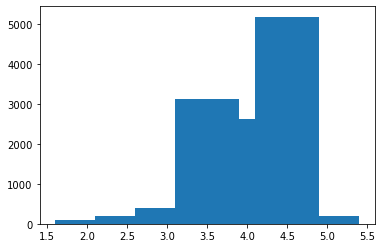

In [24]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.bar(df['Rating'],df['Review Count'])

In [29]:
thaidf=thaidf[thaidf['Rating']!='Rating']
thaidf['Rating']=thaidf['Rating'].astype(float)
mexdf=mexdf[mexdf['Rating']!='Rating']
mexdf['Rating']=mexdf['Rating'].astype(float)

(1.0, 5.0)

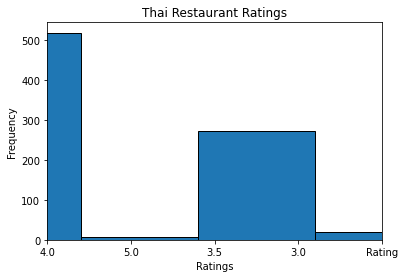

In [25]:
thaidf
fig,ax=plt.subplots()
ax.hist(thaidf['Rating'],edgecolor='black',bins=5)
ax.set_title('Thai Restaurant Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_xlim(1.0,5.0)

(1.0, 5.0)

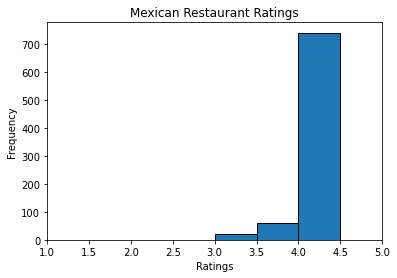

In [31]:
fig,ax=plt.subplots()
ax.hist(mexdf['Rating'],edgecolor='black',bins=3)
ax.set_title('Mexican Restaurant Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency')
ax.set_xlim(1.0,5.0)

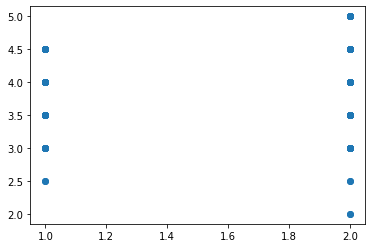

In [26]:
fig,ax=plt.subplots()
ax.scatter(df['Price'].map(len),df['Rating'])

In [32]:
df['Transactions']=df['Transactions'].astype(str)

In [33]:
def conversion(string):
    string=string.split(',')
    return string
df['Transactions']=df['Transactions'].map(conversion)

In [68]:
# fig,ax=plt.subplot()
# plt.hist(df['Transactions'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1624 entries, Sup Thai Kitchen to Los Portales
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1624 non-null   object 
 1   Location      1622 non-null   object 
 2   Rating        1624 non-null   float64
 3   Price         1624 non-null   object 
 4   Zipcode       1624 non-null   object 
 5   Transactions  1624 non-null   object 
 6   Review Count  1624 non-null   int64  
 7   Categories    1624 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 154.2+ KB


In [63]:
df['Id']=df['Id'].astype(str)

In [48]:
top_restaurant = highest_rated.iloc[0]

In [71]:
reviewsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  879 non-null    float64
 1   ID          881 non-null    object 
 2   Review      881 non-null    object 
 3   Rating      881 non-null    object 
 4   Date        881 non-null    object 
dtypes: float64(1), object(4)
memory usage: 34.5+ KB


In [78]:
reviewsdf.rename_axis(mapper='Id', axis = 1)

In [27]:
reviewsdf

,Unnamed: 0,Id,Review,Rating,Date
0,0.0,eoqQ6cSoPLOd7YWAjWNS4A,"Sadly due to Covid 19 disaster , we avoid eati...",5,2020-12-25 15:29:31
1,1.0,jth1qrL_taRqkxNe0r5xSw,Sup Thai Kitchen was recommended by our friend...,5,2020-11-14 18:27:22
2,2.0,qZbZ7qQ8omuIMgq-Ju5adA,Sup means treasure/asset in Thai and this re...,5,2020-11-08 17:15:23
3,3.0,rKMbqLwkCBIuh6KXE7jxlA,I have been ordering from here via Uber eats d...,5,2021-01-05 03:06:27
4,4.0,-MzURutxJoE3hK_QAi3LEQ,This is my top thai spot for dining-in and del...,5,2020-12-05 19:14:25
...,...,...,...,...,...
897,295.0,MQLhVomipLY0PFd33puBdA,I've been meaning to submit this review for a ...,5,2020-08-28 00:10:10
898,296.0,SxR1ysTSQeyzdVMVsS1MlA,Klong was me and my friends place pre-covid. W...,5,2020-08-29 12:42:37
899,297.0,xKGgRDpuUXOS0z6Y5BhLJg,I feel like this spot serves some of the best ...,5,2020-09-13 11:39:47
900,298.0,4aT9AMLmEH75RPxA7uMKMA,Favorite local Thai take out spot! I'm a veget...,5,2020-12-07 10:07:52


In [28]:
df.where(df['Id']==reviewsdf['Id']).notna()

ValueError: Can only compare identically-labeled Series objects

In [29]:
mergedStuff = pd.merge(df, reviewsdf, on=['Id'], how='inner')

In [30]:
mergedStuff

,Id,Location,Rating_x,Price,Zipcode,Transactions,Review Count,Categories,Unnamed: 0,Review,Rating_y,Date


In [31]:
df['Id'].isin(reviewsdf['Id']).value_counts()

False    1624
Name: Id, dtype: int64

___

# Reference help

###  Pagination

Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retriving 50 at a time. Processes such as these are often refered to as pagination.

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. 

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and APIs can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

***Below is sample code that you can use to help you deal with the pagination parameter and bring all of the functions together.***


***Also, something might cause your code to break while it is running. You don't want to constantly repull the same data when this happens, so you should insert the data into the database as you call and parse it, not after you have all of the data***


In [ ]:
# create a variable  to keep track of which result you are in. 
cur = 0

#set up a while loop to go through and grab the result 
while cur < num and cur < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = cur
    #make your API call with the new offset number
    results = yelp_call(url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    db_insert(parsed_results)
    #increment the counter by 50 to move on to the next results
    cur += 20